# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

** This is the second attempt to solve the project, in which only the images test will be conducted. **

---

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 
import os, glob
import math
%matplotlib inline

## Define Functions

In [8]:
# All OpenCV functions directly comes from the provided "Helper Functions"

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# ======================================================================================================
# draw_lines() comes from galenballew
# https://github.com/galenballew/SDC-Lane-and-Vehicle-Detection-Tracking/blob/master/Part%20I%20-%20Simple%20Lane%20Detection/P1.ipynb
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
# define slope
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    
    """workflow:
    1) examine each individual line returned by hough & determine if it's in left or right lane 
    by its slope because we are working "upside down" with the array, the left lane will have a 
    negative slope and right positive
    2) track extrema
    3) compute averages
    4) solve for b intercept 
    5) use extrema to solve for points
    6) smooth frames and cache
    """
    global cache
    global first_frame
    

    y_global_min = img.shape[0] #min will be the "highest" y value, or point down the road away from car
    y_max = img.shape[0]
    l_slope, r_slope = [],[]
    l_lane,r_lane = [],[]
    det_slope = 0.4
    α =0.2 
    #i got this alpha value off of the forums for the weighting between frames.
    #i understand what it does, but i dont understand where it comes from
    #much like some of the parameters in the hough function
    
    for line in lines:
        #1
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            if slope > det_slope:
                r_slope.append(slope)
                r_lane.append(line)
            elif slope < -det_slope:
                l_slope.append(slope)
                l_lane.append(line)
        #2
        y_global_min = min(y1,y2,y_global_min)
    
    # to prevent errors in challenge video from dividing by zero
    if((len(l_lane) == 0) or (len(r_lane) == 0)):
        print ('no lane detected')
        return 1
        
    #3
    l_slope_mean = np.mean(l_slope,axis =0)
    r_slope_mean = np.mean(r_slope,axis =0)
    l_mean = np.mean(np.array(l_lane),axis=0)
    r_mean = np.mean(np.array(r_lane),axis=0)
    
    if ((r_slope_mean == 0) or (l_slope_mean == 0 )):
        print('dividing by zero')
        return 1
        
    #4, y=mx+b -> b = y -mx
    l_b = l_mean[0][1] - (l_slope_mean * l_mean[0][0])
    r_b = r_mean[0][1] - (r_slope_mean * r_mean[0][0])
    
    #5, using y-extrema (#2), b intercept (#4), and slope (#3) solve for x using y=mx+b
    # x = (y-b)/m
    # these 4 points are our two lines that we will pass to the draw function
    l_x1 = int((y_global_min - l_b)/l_slope_mean) 
    l_x2 = int((y_max - l_b)/l_slope_mean)   
    r_x1 = int((y_global_min - r_b)/r_slope_mean)
    r_x2 = int((y_max - r_b)/r_slope_mean)
    
    #6
    if l_x1 > r_x1:
        l_x1 = int((l_x1+r_x1)/2)
        r_x1 = l_x1
        l_y1 = int((l_slope_mean * l_x1 ) + l_intercept)
        r_y1 = int((r_slope_mean * r_x1 ) + r_intercept)
        l_y2 = int((l_slope_mean * l_x2 ) + l_intercept)
        r_y2 = int((r_slope_mean * r_x2 ) + r_intercept)
    else:
        l_y1 = y_global_min
        l_y2 = y_max
        r_y1 = y_global_min
        r_y2 = y_max
        
    current_frame = np.array([l_x1,l_y1,l_x2,l_y2,r_x1,r_y1,r_x2,r_y2],dtype ="float32")
    
    if first_frame == 1:
        next_frame = current_frame        
        first_frame = 0        
    else :
        prev_frame = cache
        next_frame = (1-α)*prev_frame+α*current_frame
             
    cv2.line(img, (int(next_frame[0]), int(next_frame[1])), (int(next_frame[2]),int(next_frame[3])), color, thickness)
    cv2.line(img, (int(next_frame[4]), int(next_frame[5])), (int(next_frame[6]),int(next_frame[7])), color, thickness)
    
    cache = next_frame
# =========================================================================================================

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    #lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# ========================================================================
# show_images() refers to naokishibuya 
# https://github.com/naokishibuya/car-finding-lane-lines/blob/master/Finding%20Lane%20Lines%20on%20the%20Road.ipynb
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

## Test Images

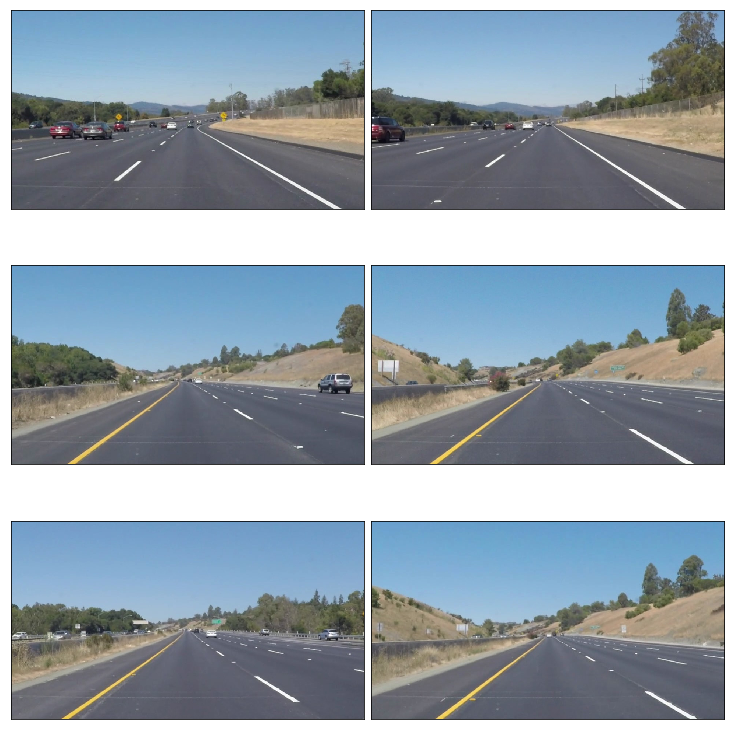

In [9]:
# load in the test images
for source_img in os.listdir("test_images/"):
    first_frame = 1
    image = mpimg.imread("test_images/"+source_img)
    
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]    
show_images(test_images)    

**RGB Color Space**

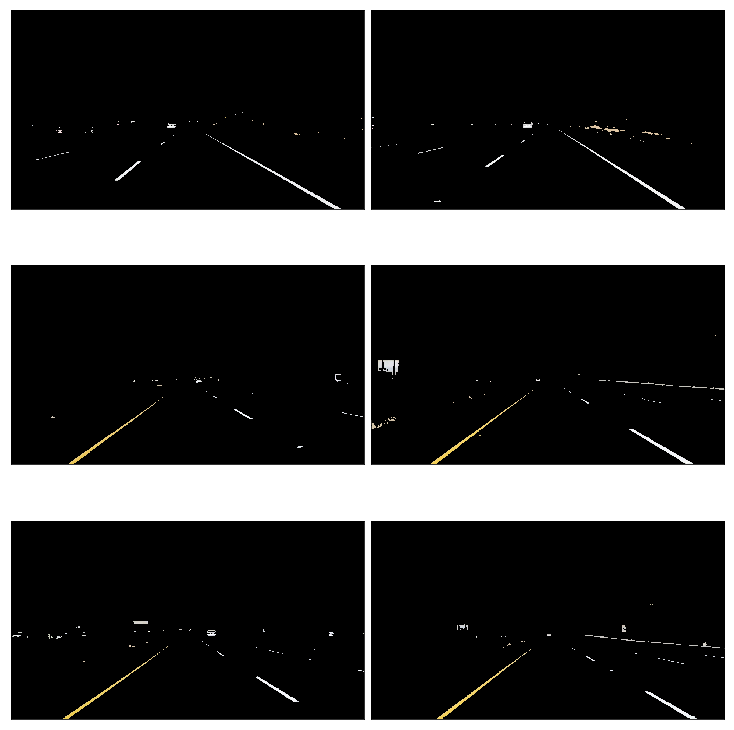

In [10]:
# creat mask to select only white and yellow colors in the images

def rgb_white_yellow(image): 
    
    # OpenCV and Python Color Detection: https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/ 
    # white color mask
    # white color code: http://www.rapidtables.com/web/color/white-color.htm#chart
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    
    # yellow color mask 
    # yellow color codes: http://www.rapidtables.com/web/color/Yellow_Color.htm
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 200])
    yellow_mask = cv2.inRange(image, lower, upper)
    
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    
    return masked

white_yellow_images = list(map(rgb_white_yellow, test_images)) 
# map(function_to_apply, list_of_inputs) 

show_images(white_yellow_images)

** Process Images**

In [17]:
# process images using OpenCV
def process_images():
    
    global first_frame
    
    # change white and yellow images into gray scale for later edge detection
    gray_images = list(map(grayscale, white_yellow_images))
    #show_images(gray_images)

    # apply the Gaussian blurring 
    # define a kernel size for Gaussian smoothing / blurring 
    kernel_size = 7
    blurred_gray = list(map(lambda img: gaussian_blur(img, kernel_size), gray_images))
    # map: http://book.pythontips.com/en/latest/map_filter.html
    #show_images(blurred_gray)
    
    # apply the Canny Edge Detection
    low_threshold = 50
    high_threshold = 150
    edge_images = list(map(lambda img: canny(img, low_threshold, high_threshold), blurred_gray))
    #show_images(edge_images)
    
    # define region of interest 
    imshape = image.shape
    lower_left = [imshape[1]*0.1,imshape[0]]
    top_left = [imshape[1]*0.45,imshape[0]*0.6]
    top_right = [imshape[1]*0.6,imshape[0]*0.6]
    lower_right = [imshape[1]*0.9,imshape[0]]
    vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
    # images of the region of interest 
    roi_images = list(map(lambda img: region_of_interest(img, vertices), edge_images))
    
    #show_images(roi_images)
    
    # conduct Hough Transform line detection
    # define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    
    hough_images = list(map(lambda img: hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap), roi_images))
    
    draw_image = np.copy(image)*0
    
    line_images = list(map(lambda lines: draw_lines(draw_image, lines, color=[255, 0, 0], thickness=6), hough_images))
    print_images = list(map(lambda img: weighted_img(img, image, α=0.8, β=1., λ=0.), line_images))
    
    show_images(print_images)

process_images()  
    

error: ..\..\..\modules\core\src\arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function cv::arithm_op


In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# =======================================================================
# Transfering the first picture into grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY) # grayscale conversion 
plt.imshow(gray1, cmap = 'gray') # plot the grayscaled picture 

In [ ]:
# apply the Canny edge detector

# define a kernel size for Gaussian smoothing / blurring 
kernel_size =7
blur_gray1 = cv2.GaussianBlur(gray1, (kernel_size, kernel_size), 0)

# define parameters for Canny 
low_threshold = 50
high_threshold = 150
edges1 = cv2.Canny(blur_gray1, low_threshold, high_threshold)
# display the image 
plt.imshow(edges1, cmap = 'Greys_r')

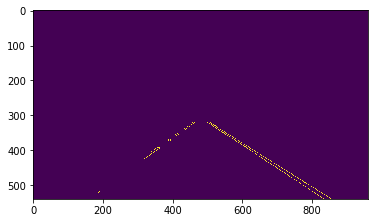

In [78]:
# create a masked edges image using cv2.fillPoly()
mask1 = np.zeros_like(edges1)   
ignore_mask_color = 255

# define a four sided polygon to mask
imshape1 = image1.shape
vertices1 = np.array([[(160, imshape1[0]), (450, 320), (540, 320), (imshape1[1],imshape1[0])]], dtype=np.int32)
cv2.fillPoly(mask1, vertices1, ignore_mask_color)
masked_edges1 = cv2.bitwise_and(edges1, mask1)
plt.imshow(masked_edges1)

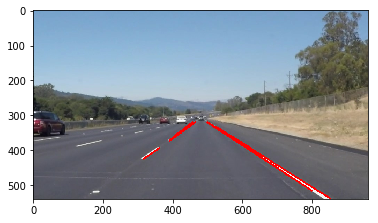

In [82]:
# define the Hough transform parameters
# make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image1 = np.copy(image1) # creating a blank to draw lines on

# run Hough on edge detected image
lines1 = cv2.HoughLinesP(masked_edges1, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

# Iterate over the output "lines1" and draw lines on the blank
for line in lines1:
    for x1, y1, x2, y2 in line:
        cv2.line(line_image1, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
# creat a color binary image to combine with line image
#color_edges1 = np.dstack((edges1, edges1, edges1))

# Draw the lines on the edge image
#lines_edges1 = cv2.addWeighted(color_edges1, 0.8, line_image1, 1, 0) 
#plt.imshow(lines_edges1)

plt.imshow(line_image1)
